# ANALYSIS

### Imports

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import PIL
import os
import sys
import glob
import random
from config import *

from pprint import pprint

from PIL import Image
from PIL.ExifTags import TAGS

def imshow(a):
    a = a.clip(0, 255).astype('uint8')
    if a.ndim == 3:
        if a.shape[2] == 4:
            a = cv2.cvtColor(a, cv2.COLOR_BGRA2RGBA)
    else:
        a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
    image = PIL.Image.fromarray(a)
    new_image = image.resize((250, 400))
    display(new_image)

## Overall Basic Data

#### RGB histograms

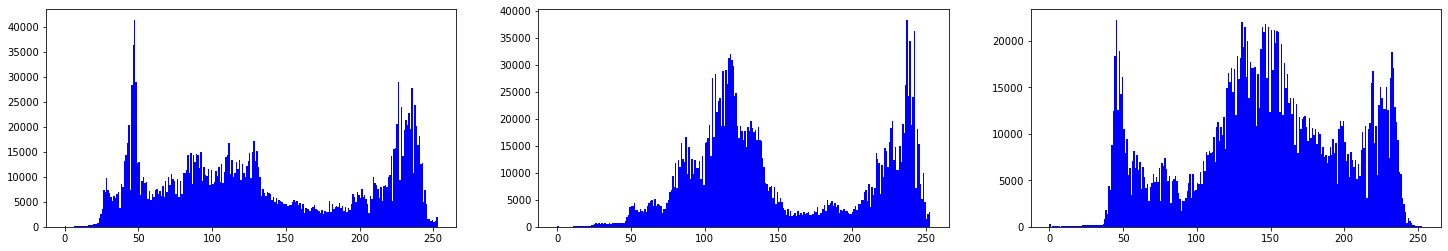

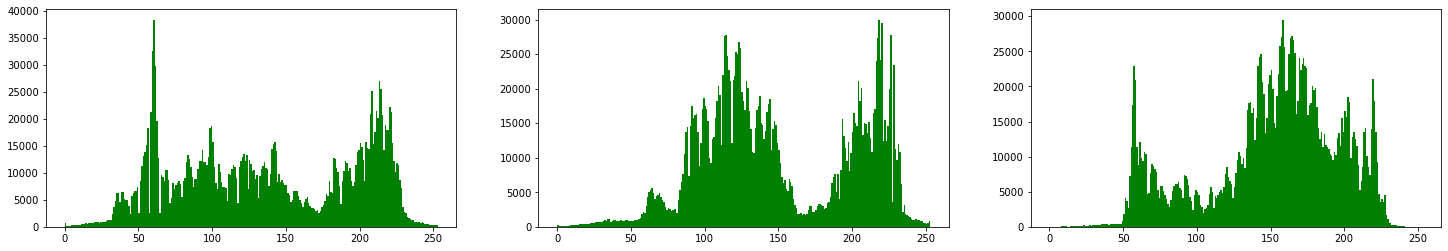

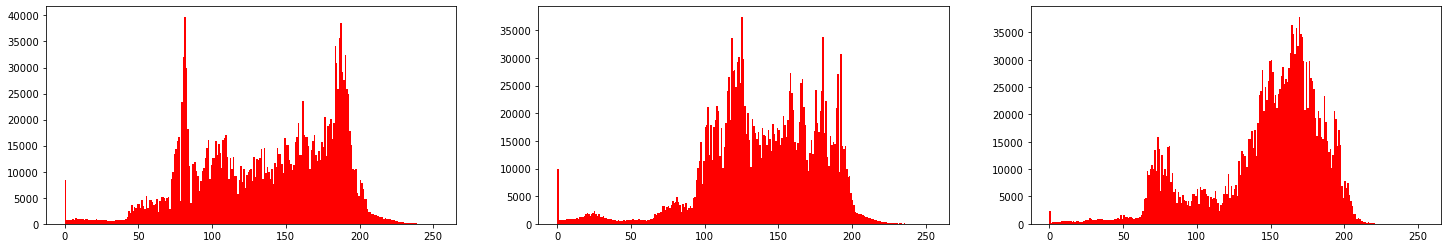

In [10]:
f = cv2.VideoCapture('videos\easy.mp4')
rval_easy, frame_easy = f.read()
f = cv2.VideoCapture('videos\shadow.mp4')
rval_shadow, frame_shadow = f.read()
f = cv2.VideoCapture('videos\hard.mp4')
rval_hard, frame_hard = f.read()
COLORS = ['blue', 'green', 'red']
for color in range(3):
  fig, axes = plt.subplots(1, 3)
  fig.set_size_inches(25,4)
  for i, pic in enumerate([frame_easy, frame_shadow, frame_hard]):
    axes[i].hist(pic[:,:,color].ravel(),253,[0,253], color = COLORS[color])

GRAYSCALE histograms

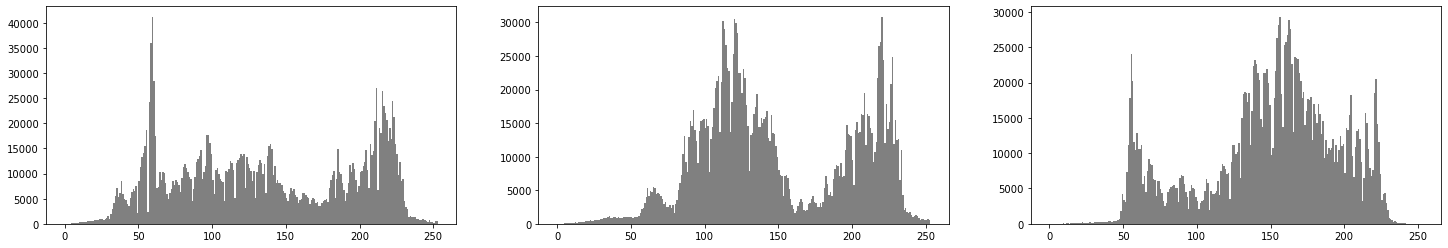

In [11]:
fig, axes = plt.subplots(1, 3)
fig.set_size_inches(25,4)
for i, pic in enumerate([frame_easy, frame_shadow, frame_hard]):
  pic = cv2.cvtColor(pic, cv2.COLOR_RGB2GRAY)
  axes[i].hist(pic[:,:].ravel(),253,[0,253], color = 'gray')

## Approximate Board Placement

This quite mundane feature seemed to be the thing that brought us the most distress. To clear things out in the beginning, we starting working on the project when having a dataset of a ludo game with clearly visible corners, later we decided to change the dataset but stuck to the method used.

##### Rough outline of the idea

We decided to track the 4 corners of the board by using a multitracker: see

In [12]:
def createMultitracker(bboxes):
        multiTracker = cv2.MultiTracker_create()
        # Initialize MultiTracker
        for bbox in bboxes:
                print(bbox)
                for corner in bbox:
                        print(corner)
                        for trackerType in trackerTypes:
                                multiTracker.add(createTrackerByName(trackerType), frame, (corner[0] - WIDTH_BOXIE , corner[1] -WIDTH_BOXIE, WIDTH_BOXIE*2, WIDTH_BOXIE*2))
        return multiTracker

which is created by using bounding boxes, of the square detected (board), for this a square detector method is used:

In [13]:
def find_squares(img, boxes):
    image = img.copy()
    # HEURISTIC : board not smaller than 30% of the board and not bigger than 90%
    size_of_image = image.shape[0]* image.shape[1]
    lower_bound_board_size = 0.33 * size_of_image
    upper_bound_board_size = 0.9 * size_of_image

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.medianBlur(gray, 9)
    sharpen_kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    sharpen = cv2.filter2D(blur, -1, sharpen_kernel)

    # Threshold and morph close
    thresh = cv2.threshold(sharpen, 150, 255, cv2.THRESH_BINARY_INV)[1]
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    close = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=1)
    cnts, _ = cv2.findContours(close, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)
    for contour in cnts:
        approx = cv2.approxPolyDP(contour, 0.01* cv2.arcLength(contour, True), True)
        x, y , w, h = cv2.boundingRect(approx)
        aspectRatio = float(w)/h
        if  aspectRatio >0.9 and aspectRatio < 1.1 and cv2.contourArea(contour) > 100 and len(approx)< 10 and cv2.contourArea(contour) > lower_bound_board_size and cv2.contourArea(contour) < upper_bound_board_size:
            rect = cv2.minAreaRect(contour)
            box = cv2.boxPoints(rect)
            box = np.int0(box)
            box = chizzledBox(box, image) # box chizzeling
            print("chizzled box: ", box)
            add_shape(box, boxes)
        
    for box in boxes.values():
        pts = np.array(box, np.int32)
        pts = pts.reshape((-1,1,2))
        cv2.polylines(close,[pts],True,100)
    return img, thresh, boxes

We use openCv functionalities to find a rectangle with the appropriate aspect ratio ( a board should have ), then we bound it using a minimum Area rectangle and funally chizzle the rectangle ( since the board can be in a non-rectangular configuartion ( captured at an angle )) using adaptive theresholds on the edges and multimode operations.


This might seem like an overkill, but it's the best way I've found. Since corner tracking was found to be one of the cheaper methods considered by us, but without the chizzeling and **recalculation of corners if area of board changes by more than 1% leads to poor performance (non overlapping of the board) like: 


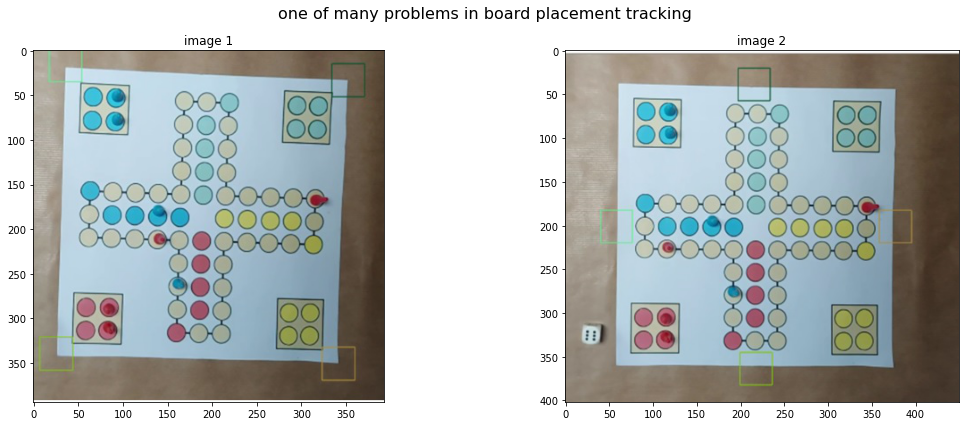

In [14]:
import matplotlib.pyplot as plt
img1 = plt.imread(r'reportPics\propper.jpg')
img2 = plt.imread(r'reportPics\unpropper.jpg')

NUM_ROWS = 1
IMGs_IN_ROW = 2
f, ax = plt.subplots(NUM_ROWS, IMGs_IN_ROW, figsize=(16,6))

ax[0].imshow(img1)
ax[1].imshow(img2)

ax[0].set_title('image 1')
ax[1].set_title('image 2')

title = 'one of many problems in board placement tracking'
f.suptitle(title, fontsize=16)
plt.tight_layout()
plt.show()

## Field Placement

For us to have the coordinates of the fields we empirically found out that in our example simple circle detection would not cut it, especially since we already got the board placement figured out. 

We decided to use our self designed Ludo board for help in that matter in *static_recognition.py* we compiled the funcions usef for that, here is how we done it:

1. First find out about the field placement ( use pimple Blob detector )

2. Second find out what the "special fields"  are:

         __                  __
        |tl|       tr       |tr|
                   tr    
                   tr
                   tr
        tl tl tl tl  br br br br br
                   bl
                   bl
         __        bl        __
        |bl|       bl       |br|

3. Create a hashmap for fields 1-72 with different ranges for each special field and regular fields.

## Token detection 

This is obviously the most important part! The is no ludo w/o the tokens! in order to make token detection happen, we subtract the pixel values of the board in frame ( after rotation etc ) from the original board values ( those will be lighter for the mostpart), next we compute the differences for each fields, and get the hue from the frame  and compute the weighted average hue ( weight is severity of difference). **But there is a catch!** in order to properly detect red tokens we have to set the hue of the pixels with orihinal H value < 10 to 180. Since red is on botch sides of the spectrum.

## Shadow correction 

For the shadow dataset and not only (it was vital for the other two datasets too) t was necessary to perform a shadow correction, 
for this we did inpainting of the boards (masking out the fields and bases ) on the difference of coloration and later added the artificial shadow to the original board then detecting tokens.


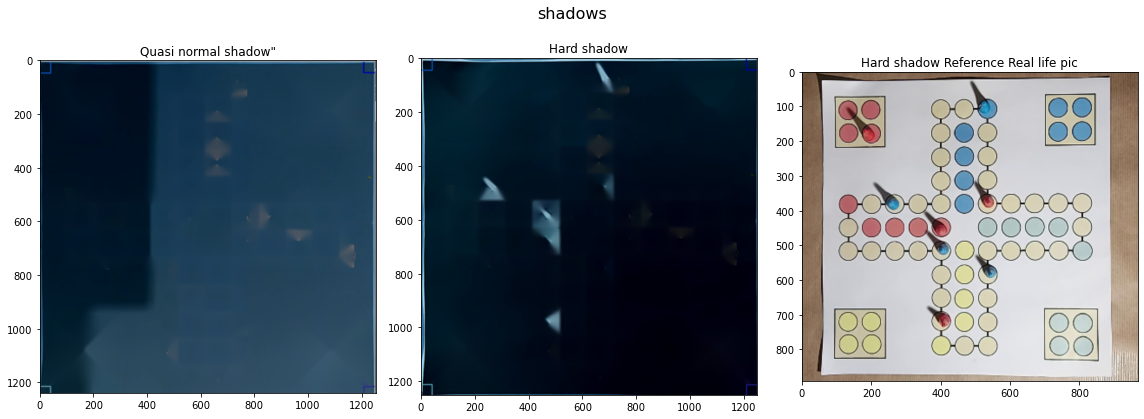

In [6]:
import matplotlib.pyplot as plt
img1 = plt.imread(r'reportPics/shadowOnly.jpg')
img2 = plt.imread(r'reportPics/shadowHard.jpg')
img3 = plt.imread(r'reportPics/shadowHardReference.jpg')

NUM_ROWS = 1
IMGs_IN_ROW = 3
f, ax = plt.subplots(NUM_ROWS, IMGs_IN_ROW, figsize=(16,6))

ax[0].imshow(img1)
ax[1].imshow(img2)
ax[2].imshow(img3)

ax[0].set_title('Quasi normal shadow"')
ax[1].set_title('Hard shadow')
ax[2].set_title('Hard shadow Reference Real life pic')

title = 'shadows'
f.suptitle(title, fontsize=16)
plt.tight_layout()
plt.show()

In [15]:
def getShadowMask(img, originalBoard, maskFields):
        lower = np.array([200]) #lower red color limit
        upper = np.array([255]) # upper limit
        mask = cv2.dilate(cv2.inRange(maskFields,lower,upper), np.ones((15, 15), np.uint8)) + maskOnBases
        imgNoFields = img.copy()
        originalNoFields = originalBoard.copy()
        imgNoFields[mask > 100] = 0
        originalNoFields[mask > 100] = 0
        lights = cv2.subtract(originalNoFields, imgNoFields)
        dstLights = cv2.inpaint(lights,mask,5,cv2.INPAINT_TELEA)
        return dstLights

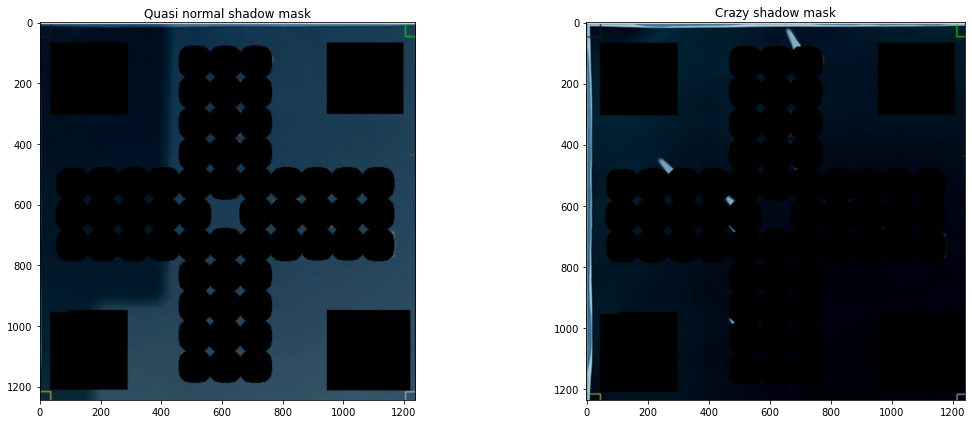

In [12]:
img1 = plt.imread(r'reportPics/masksShadow.png')
img2 = plt.imread(r'reportPics/masksShadow2.png')

NUM_ROWS = 1
IMGs_IN_ROW = 2
f, ax = plt.subplots(NUM_ROWS, IMGs_IN_ROW, figsize=(16,6))

ax[0].imshow(img1)
ax[1].imshow(img2)

ax[0].set_title('Quasi normal shadow mask')
ax[1].set_title('Crazy shadow mask')
plt.tight_layout()
plt.show()

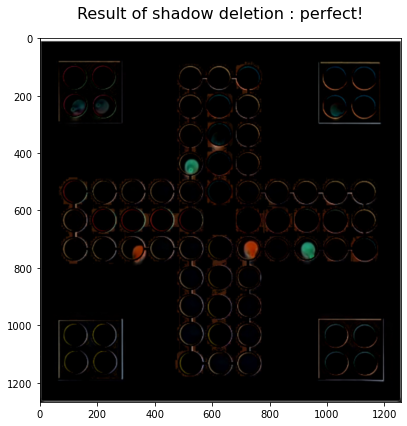

In [8]:
import matplotlib.pyplot as plt
img1 = plt.imread(r'reportPics\shadow.jpg')

NUM_ROWS = 1
IMGs_IN_ROW = 1
f, ax = plt.subplots(NUM_ROWS, IMGs_IN_ROW, figsize=(16,6))

ax.imshow(img1)

title = 'Result of shadow deletion : perfect!'
f.suptitle(title, fontsize=16)
plt.tight_layout()
plt.show()

## Universality of our approach: Board rotation


It strikes one as obvious, but one can obviously play ludo on many angles, bor this reason we decided to milement board rotation ( so a dataset of the board upside down would work as well as a dataset with the ludo board in any other direction)

# Hand Detection

We decided to treat the act of moving tokens as an event itself - since infference of token placement is inhibited in that time.

We tried hard but the best idea we came up with was masking a ranke in the hsv image format - obviously not all regions in the image are equally as important, so we put a higher importance on regions on the board and especially near the corners.

See the mask below:

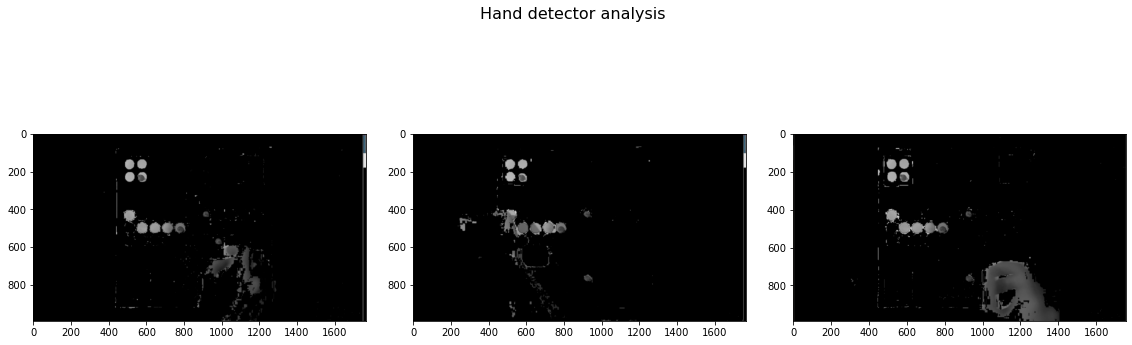

In [13]:
img1 = plt.imread(r'reportPics/hand1.png')
img2 = plt.imread(r'reportPics/hand2.png')
img3 = plt.imread(r'reportPics/hand3.png')

NUM_ROWS = 1
IMGs_IN_ROW = 3
f, ax = plt.subplots(NUM_ROWS, IMGs_IN_ROW, figsize=(16,6))

ax[0].imshow(img1)
ax[1].imshow(img2)
ax[2].imshow(img3)

title = 'Hand detector analysis'
f.suptitle(title, fontsize=16)
plt.tight_layout()
plt.show()

## Dice detection

For the detection of the dice and its value we first look for circles (blobs) and then cluster them.


# Summary

We did the "hardest" version of the projects, but we encountered many hardhips needing many, many tweaks, therefore the program is quite slow.
Many solutions are not mentioned here, as well as most of the thoight process that went to this project.
